In [1]:
import sys
sys.path.append('..')

import numpy as np
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import glob
import seaborn as sns

from model import *
from utils import *
import pandas as pd

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def load_model(model, exp_name, ckpt=0, final=False, best=False, file_name=None):
    if file_name:
        fn = file_name
    elif best:
        fn = 'best-model.pth'
    elif final:
        fn = 'final-model.pth'
    else:
        fn = f'checkpoint-{ckpt}.pth'
    model_path = f'/mnt/cfs/sihaozhe/ss-dfd/exp/{exp_name}/model/{fn}'
    model_dict = torch.load(model_path)
    state_dict = model_dict['model']
    model.load_state_dict(state_dict)
    return model_dict['iter']

In [3]:
def eval_depth(pred, gt):
    error = torch.abs(gt - pred)
    AbsRel = torch.mean(error / gt)
    SqRel = torch.mean(error ** 2 / gt)
    RMSE = torch.sqrt(torch.mean(error ** 2))
    RMSE_log = torch.sqrt(torch.mean(torch.abs(torch.log10(gt+1e-8) - torch.log10(pred+1e-8)) ** 2))
    gt_pred = gt/pred
    pred_gt = pred/gt
    acc = torch.max(gt_pred, pred_gt)
    delta1 = torch.sum(acc < 1.25)/(acc.shape[-1] * acc.shape[-2])
    delta2 = torch.sum(acc < 1.25**2)/(acc.shape[-1] * acc.shape[-2])    
    delta3 = torch.sum(acc < 1.25**3)/(acc.shape[-1] * acc.shape[-2])
    return AbsRel, SqRel, RMSE, RMSE_log, delta1, delta2, delta3

def eval_aif(inp):
    dy = inp[:, :, :, :] - F.pad(inp[:, :, :-1, :], (0, 0, 1, 0))
    dx = inp[:, :, :, :] - F.pad(inp[:, :, :, :-1], (1, 0, 0, 0))
    MG = torch.mean(torch.sqrt((dx ** 2 + dy ** 2)/2), dim=[1,2,3]) # Large -> Better
    SF = torch.sqrt(torch.mean(dx ** 2, dim=[1,2,3]) + torch.mean(dy ** 2, dim=[1,2,3])) # Large -> Better
    return MG.mean(), SF.mean()

In [4]:
def dpt_post_op(dpt, post_op, near=0.1, far=10.):
    if post_op == 'clip':
        dpt = torch.clip(dpt, 0, far).detach().cpu()
    elif post_op == 'norm':
        dpt_local_min = torch.min(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        dpt_local_max = torch.max(dpt.view(1, -1), dim=1)[0].view(1, 1, 1)
        norm_dpt_ = dpt / (dpt_local_max + 1e-8)
        # norm_dpt_ = (dpt - dpt_local_min)/(dpt_local_max - dpt_local_min + 1e-8)
        norm_dpt = norm_dpt_ * (far - near) + near
        dpt = norm_dpt.detach().cpu()
    return dpt

In [8]:
def num_params(model):
    return sum([param.nelement() for param in model.parameters()])

In [6]:
device = 0
BS = 1
use_cuda = True

In [7]:
data_path = '/mnt/cfs/sihaozhe/data/mobileDFD/'

In [167]:
cam_far = 10
dataset_config = {
    'root_dir': data_path,
    'visible_img': 5,
    'recon_all': False,
    'scale': 1,
    'near': 0.1,
    'far': 10,
}

In [168]:
torch.cuda.set_device(device)


In [12]:
# camera = ThinLenCamera(pixel_size=5.6e-6)
camera = ThinLenCamera(fnumber=22, focal_length=50*1e-3, pixel_size=5.6e-6)
render = GaussPSF(7)
render.cuda()
model = FUNet(4, 4)
num_params(model)/1e6

1.963821

In [226]:
train_dl, _, test_dl = load_data(dataset_config, "mobileDFD", 1, n_shot=1, indices=[1])


5 images per sample are visible for input
Using Indices: [1]
Total number of sample: 1


In [227]:
dl = iter(test_dl)


360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640
360 640


In [182]:
sample = next(dl)


In [183]:
sample['output_fd']


tensor([[1.4858, 1.4502, 1.2179, 1.0062, 0.8546, 0.7638, 0.6996, 0.6353, 0.5703,
         0.4921, 0.4715, 0.4488, 0.4275, 0.3950, 0.3831, 0.3687, 0.3572, 0.3349,
         0.3237, 0.3149, 0.3045, 0.2858, 0.2766, 0.2693, 0.2542, 0.2530, 0.2540]])

In [189]:
sub_idx = np.linspace(0, 27-1, 5).round().astype(int)
sub_idx


array([ 0,  6, 13, 20, 26])

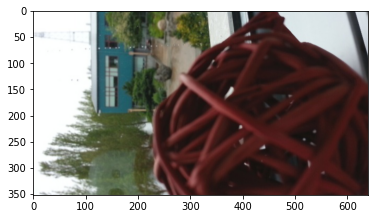

In [178]:
plt.imshow(sample['rgb_fd'][0, -1, :-1].numpy().transpose(1, 2, 0))

## Model Eval

In [154]:
ckpt = 1500
final = False
best = True
post_op = 'norm'
# model_names = ['NYU_100_FS5', 'NYU_100_FS5_CAM']
model_names = ['mobileDFD_FS5_2_9']


In [157]:
exp_name = f'{model_names[0]}'
n_iter = load_model(model, exp_name, ckpt, best=best)
model = model.cuda()
pred_dpts = []
pred_aifs = []
for i, batch in enumerate(tqdm(test_dl)):
    with torch.no_grad():
        raw_aif_dpt = model(batch['rgb_fd'].cuda())
        raw_aif = raw_aif_dpt[:, :-1]
        raw_dpt = raw_aif_dpt[:, -1]
    pred_dpt = dpt_post_op(raw_dpt, post_op, far=1.5)
    pred_aif = torch.clip(raw_aif, 0, 1)
    pred_dpts.append(pred_dpt)
    pred_aifs.append(pred_aif)    

  0%|          | 0/1 [00:01<?, ?it/s]

([], [])

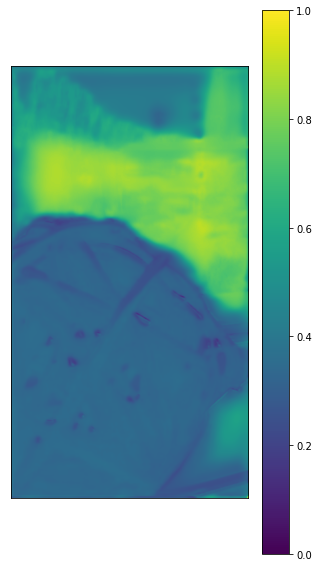

In [159]:
# plt.figure(figsize=(15, 10))
plt.figure(figsize=(5, 10))
# plt.subplot(1, 2, 1)
# plt.title('Pred AIF')
# plt.imshow(np.flip(pred_aif[0].cpu().numpy().transpose(2, 1, 0), axis=1))
# plt.subplot(1, 2, 2)
# plt.title('Pred Depth')
plt.imshow(np.flip(pred_dpts[0][0].cpu().numpy().transpose(1, 0), axis=1), cmap='viridis')
plt.colorbar(fraction=0.1)
plt.clim(0.,1)
plt.xticks([])
plt.yticks([])
# plt.savefig(f'paper_img/mdfd_ft_0_dpt.pdf')


([], [])

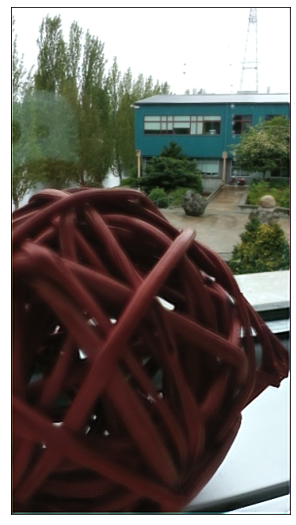

In [160]:
plt.figure(figsize=(5, 10))
plt.imshow(np.flip(pred_aifs[0][0].cpu().numpy().transpose(2, 1, 0), axis=1))
plt.xticks([])
plt.yticks([])
# plt.savefig(f'paper_img/mdfd_ft_0_paif.pdf')


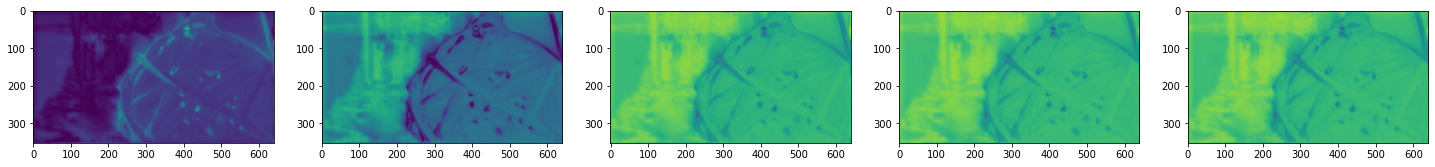

In [148]:
B, FS, C, H, W = batch['output'].shape
dpt = pred_dpt.expand(FS, H, W)
fd = batch['output_fd'].view(-1, 1, 1).expand_as(dpt)
defocus = camera.getCoC(dpt, fd).unsqueeze(1)
plt.figure(figsize=(25, 6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(defocus[i, 0].cpu().numpy())


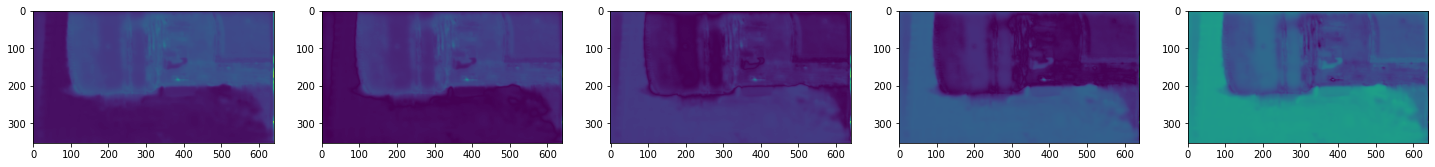

In [130]:
B, FS, C, H, W = batch['output'].shape
dpt = pred_dpt.expand(FS, H, W)
fd = batch['output_fd'].view(-1, 1, 1).expand_as(dpt)
defocus = camera.getCoC(dpt, fd).unsqueeze(1)
plt.figure(figsize=(25, 6))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(defocus[i, 0].cpu().numpy())

In [131]:
inp_fs = batch['rgb_fd'][:, :, :-1]
clear_idx = torch.argmin(defocus.view(B, FS, 1, H, W).expand(B, FS, C, H, W), dim=1, keepdim=True)
coarse_aif = torch.gather(inp_fs, 1, clear_idx).squeeze(1)

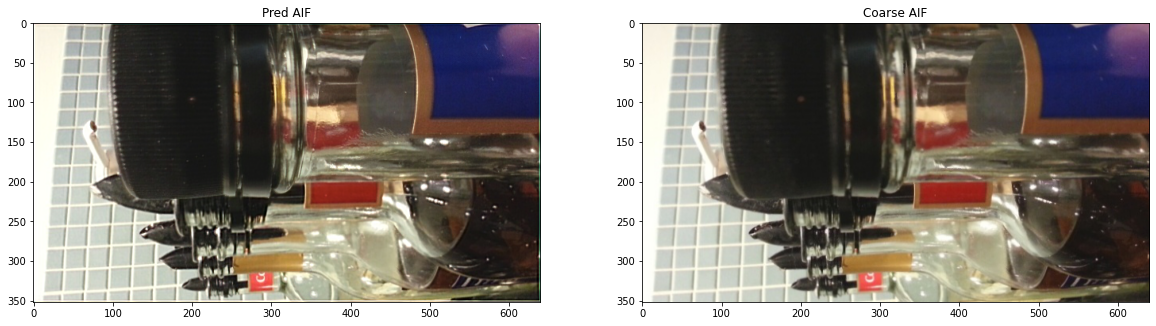

In [133]:
plt.figure(figsize=(20, 10))
# plt.subplot(1, 3, 1)
# plt.title('Ground Truth')
# plt.imshow(aif_gt[0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 1)
plt.title('Pred AIF')
plt.imshow(pred_aif[0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('Coarse AIF')
plt.imshow(coarse_aif[0].numpy().transpose(1, 2, 0))
# plt.savefig('NYU_orig_unsup_vis_aif.png', dpi=200)

In [334]:
n = 0
with open('/mnt/cfs/sihaozhe/data/Mobile_Depth/calibration/telephone/depth_var.bin', 'rb') as f:
    t = np.frombuffer(f.read(1), dtype=np.ubyte)[0]
    h = np.frombuffer(f.read(4), dtype=np.intc)[0]
    w = np.frombuffer(f.read(4), dtype=np.intc)[0]
    d = np.fromfile(f,count=w*h).reshape(h,w)
d = 1 / d 

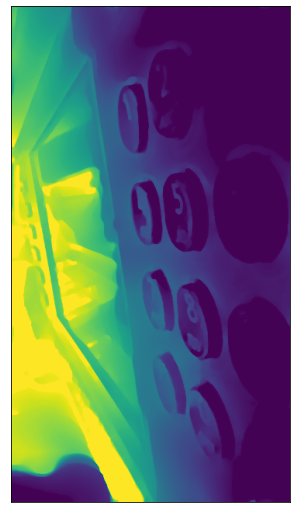

In [335]:
plt.figure(figsize=(5, 10))
aa = (d - np.min(d))/(np.max(d) - np.min(d))
plt.imshow(np.flip(1 - aa.transpose(), axis=1))
plt.xticks([])
plt.yticks([])
plt.savefig(f'paper_img/mdd_2_dpt.pdf')

In [229]:
640*360

230400

In [234]:
(np.max(a) - np.min(a))

nan

In [243]:
len(A)

0

In [275]:
np.
(t).type(np.uchar)

AttributeError: 'bytes' object has no attribute 'type'

In [278]:
np.frombuffer(t, dtype=np.ubyte)

array([6], dtype=uint8)

In [280]:
np.frombuffer(h, dtype=np.intc)

array([360], dtype=int32)

In [281]:
np.frombuffer(w, dtype=np.intc)

array([640], dtype=int32)